# Cartpole in PyTorch

## Implementing and evaluating a random search policy


A simple, yet effective, approach is to map an observation to a vector of two numbers representing two actions. The action with the higher value will be picked. The linear mapping is depicted by a weight matrix whose size is 4 x 2 since the observations are 4-dimensional in this case. In each episode, the weight is randomly generated and is used to compute the action for every step in this episode. The total reward is then calculated. This process repeats for many episodes and, in the end, the weight that enables the highest total reward will become the learned policy. This approach is called random search because the weight is randomly picked in each trial with the hope that the best weight will be found with a large number of trials.

In [ ]:
import gym
import torch

env = gym.make('CartPole-v0')

n_state = env.observation_space.shape[0]
n_action = env.action_space.n


def run_episode(env, weight):
    """simulates an episode given the input weight and returns
    the total reward.
    Here, we convert the state array to a tensor of the float type 
    because we need to compute the multiplication of the state and 
    weight tensor, torch.matmul(state, weight), for linear mapping. 
    The action with the higher value is selected using the torch.argmax() 
    operation. And don't forget to take the value of the resulting action 
    tensor using .item() because it is a one-element tensor.
    """
    state = env.reset()
    total_reward = 0
    is_done = False
    while not is_done:
        state = torch.from_numpy(state).float()
        action = torch.argmax(torch.matmul(state, weight))
        state, reward, is_done, _ = env.step(action.item())
        total_reward += reward
    return total_reward


n_episode = 1000

best_total_reward = 0
best_weight = None

total_rewards = []

for episode in range(n_episode):
    """Now, we can run n_episode. For each episode, we do the following:
        - Randomly pick the weight
        - Let the agent take actions according to the linear mapping
        - An episode terminates and returns the total reward
        - Update the best total reward and the best weight if necessary
        - Also, keep a record of the total reward
    """
    weight = torch.rand(n_state, n_action)
    total_reward = run_episode(env, weight)
    print('Episode {}: {}'.format(episode+1, total_reward))
    if total_reward > best_total_reward:
        best_weight = weight
        best_total_reward = total_reward
    total_rewards.append(total_reward)

print('Average total reward over {} episode: {}'.format(n_episode, sum(total_rewards) / n_episode))

Surprisingly, the average reward for the testing episodes is close to the maximum of 200 steps with the learned policy. Be aware that this value may vary a lot. It could be anywhere from 160 to 200.

We can also plot the total reward for every episode in the training phase:

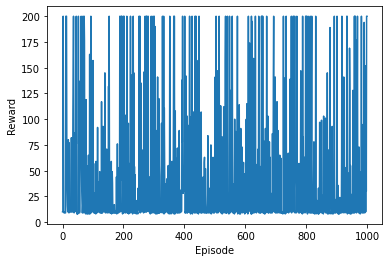

In [ ]:
import matplotlib.pyplot as plt
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

Now, let's see how the learned policy performs on 100 new episodes:

In [ ]:
n_episode_eval = 100
total_rewards_eval = []
for episode in range(n_episode_eval):
    total_reward = run_episode(env, best_weight)
    print('Episode {}: {}'.format(episode+1, total_reward))
    total_rewards_eval.append(total_reward)


print('Average total reward over {} episode: {}'.format(n_episode, sum(total_rewards_eval) / n_episode_eval))

Episode 1: 200.0
Episode 2: 200.0
Episode 3: 200.0
Episode 4: 200.0
Episode 5: 200.0
Episode 6: 200.0
Episode 7: 200.0
Episode 8: 200.0
Episode 9: 51.0
Episode 10: 200.0
Episode 11: 200.0
Episode 12: 200.0
Episode 13: 66.0
Episode 14: 200.0
Episode 15: 200.0
Episode 16: 73.0
Episode 17: 200.0
Episode 18: 51.0
Episode 19: 66.0
Episode 20: 77.0
Episode 21: 61.0
Episode 22: 73.0
Episode 23: 200.0
Episode 24: 200.0
Episode 25: 200.0
Episode 26: 74.0
Episode 27: 200.0
Episode 28: 107.0
Episode 29: 200.0
Episode 30: 200.0
Episode 31: 200.0
Episode 32: 200.0
Episode 33: 200.0
Episode 34: 200.0
Episode 35: 200.0
Episode 36: 64.0
Episode 37: 200.0
Episode 38: 62.0
Episode 39: 200.0
Episode 40: 200.0
Episode 41: 200.0
Episode 42: 61.0
Episode 43: 49.0
Episode 44: 200.0
Episode 45: 99.0
Episode 46: 86.0
Episode 47: 200.0
Episode 48: 61.0
Episode 49: 200.0
Episode 50: 98.0
Episode 51: 75.0
Episode 52: 200.0
Episode 53: 54.0
Episode 54: 89.0
Episode 55: 63.0
Episode 56: 200.0
Episode 57: 200.0
Epis

We can see that the reward for each episode is pretty random, and that there is no trend of improvement as we go through the episodes. This is basically what we expected.

In the plot of reward versus episodes, we can see that there are some episodes in which the reward reaches 200. We can end the training phase whenever this occurs since there is no room to improve. Incorporating this change, we now have the following for the training phase:

In [ ]:
n_episode = 1000
best_total_reward = 0
best_weight = None
total_rewards = []

for episode in range(n_episode):
    weight = torch.rand(n_state, n_action)
    total_reward = run_episode(env, weight)
    print('Episode {}: {}'.format(episode+1, total_reward))
    if total_reward > best_total_reward:
        best_weight = weight
        best_total_reward = total_reward
    total_rewards.append(total_reward)
    if best_total_reward == 200:
        break

Episode 1: 33.0
Episode 2: 49.0
Episode 3: 8.0
Episode 4: 8.0
Episode 5: 55.0
Episode 6: 195.0
Episode 7: 10.0
Episode 8: 25.0
Episode 9: 10.0
Episode 10: 10.0
Episode 11: 10.0
Episode 12: 60.0
Episode 13: 8.0
Episode 14: 14.0
Episode 15: 13.0
Episode 16: 10.0
Episode 17: 9.0
Episode 18: 41.0
Episode 19: 10.0
Episode 20: 83.0
Episode 21: 9.0
Episode 22: 42.0
Episode 23: 36.0
Episode 24: 49.0
Episode 25: 10.0
Episode 26: 31.0
Episode 27: 9.0
Episode 28: 200.0


The policy achieving the maximal reward is found in episode 17. Again, this may vary a lot because the weights are generated randomly for each episode. To compute the expectation of training episodes needed, we can repeat the preceding training process 1,000 times and take the average of the training episodes:

In [ ]:
n_training = 1000
n_episode_training = []
for _ in range(n_training):
    for episode in range(n_episode):
        weight = torch.rand(n_state, n_action)
        total_reward = run_episode(env, weight)
        if total_reward == 200:
            n_episode_training.append(episode+1)
            break

print('Expectation of training episodes needed: ', sum(n_episode_training) / n_training)

Expectation of training episodes needed:  13.905


The random search algorithm works so well mainly because of the simplicity of our CartPole environment. Its observation state is composed of only four variables. You will recall that the observation in the Atari Space Invaders game is more than 100,000 (which is 210 * 160 * 3) . The number of dimensions of the action state in CartPole is a third of that in Space Invaders. In general, simple algorithms work well for simple problems. In our case, we simply search for the best linear mapping from the observation to the action from a random pool.

Another interesting thing we've noticed is that before we select and deploy the best policy (the best linear mapping), random search also outperforms random action. This is because random linear mapping does take the observations into consideration. With more information from the environment, the decisions made in the random search policy are more intelligent than completely random ones.

## Developing the hill-climbing algorithm

In the hill-climbing algorithm, we start with a randomly chosen weight, and for every episode, we add some noise to the weight. If the total reward improves, we update the weight with the new one; otherwise, we keep the old weight. In this approach, the weight is gradually improved as we progress through the episodes, instead of jumping around in each episode.

In [ ]:
import torch
import gym


env = gym.make('CartPole-v0')

n_state = env.observation_space.shape[0]
n_action = env.action_space.n

def run_episode(env, weight):
    state = env.reset()
    total_reward = 0
    is_done = False
    while not is_done:
        state = torch.from_numpy(state).float()
        action = torch.argmax(torch.matmul(state, weight))
        state, reward, is_done, _ = env.step(action.item())
        total_reward += reward
    return total_reward

In [ ]:
n_episode = 1000
best_weight = torch.rand(n_state, n_action)
best_total_reward = 0
total_rewards = []

noise_scale = 0.01

for episode in range(n_episode):
    """After we randomly pick an initial weight, for each episode, 
    we do the following:
    - Add random noise to the weight
    - Let the agent take actions according to the linear mapping
    - An episode terminates and returns the total reward
    - If the current reward is greater than the best one obtained so far, 
    update the best reward and the weight
    - Otherwise, the best reward and the weight remain unchanged
    - Also, keep a record of the total reward
    """
    weight = best_weight + noise_scale * torch.rand(n_state, n_action)
    total_reward = run_episode(env, weight)
    if total_reward >= best_total_reward:
        best_total_reward = total_reward
        best_weight = weight
    total_rewards.append(total_reward)
    print('Episode {}: {}'.format(episode + 1, total_reward))

print('Average total reward over {} episode: {}'.format(n_episode, sum(total_rewards) / n_episode))

What could cause such variance? It turns out that if the initial weight is bad, adding noise at a small scale will have little effect on improving the performance. This will cause poor convergence. On the other hand, if the initial weight is good, adding noise at a big scale might move the weight away from the optimal weight and jeopardize the performance. How can we make the training of the hill-climbing model more stable and reliable? We can actually make the noise scale adaptive to the performance, just like the adaptive learning rate in gradient descent.

To make the noise adaptive, we do the following:
- Specify a starting noise scale.
- If the performance in an episode improves, decrease the noise scale. - In our case, we take half of the scale, but set 0.0001 as the lower bound.
If the performance in an episode drops, increase the noise scale. In our case, we double the scale, but set 2 as the upper bound.

In [ ]:
best_weight = torch.rand(n_state, n_action)
noise_scale = 0.01

best_total_reward = 0
total_rewards = []
for episode in range(n_episode):
    weight = best_weight + noise_scale * torch.rand(n_state, n_action)
    total_reward = run_episode(env, weight)
    if total_reward >= best_total_reward:
        best_total_reward = total_reward
        best_weight = weight
        noise_scale = max(noise_scale / 2, 1e-4)
    else:
        noise_scale = min(noise_scale * 2, 2)

    print('Episode {}: {}'.format(episode + 1, total_reward))
    total_rewards.append(total_reward)

print('Average total reward over {} episode: {}'.format(n_episode, sum(total_rewards) / n_episode))

The reward is increasing as the episodes progress. It reaches the maximum of 200 within the first 100 episodes and stays there. The average total reward also looks promising.

We also plot the total reward for every episode as follows:

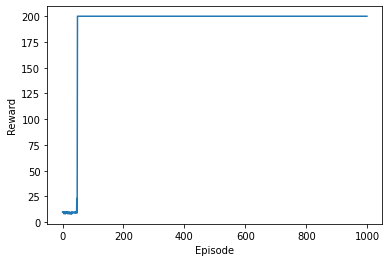

In [ ]:
import matplotlib.pyplot as plt
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

Now, let's see how the learned policy performs on 100 new episodes:

In [ ]:
n_episode_eval = 100
total_rewards_eval = []
for episode in range(n_episode_eval):
    total_reward = run_episode(env, best_weight)
    print('Episode {}: {}'.format(episode+1, total_reward))
    total_rewards_eval.append(total_reward)


print('Average total reward over {} episode: {}'.format(n_episode, sum(total_rewards_eval) / n_episode_eval))

The average reward for the testing episodes is close to the maximum of 200 that we obtained with the learned policy. You can re-run the evaluation multiple times. The results are pretty consistent.

We are able to achieve much better performance with the hill-climbing algorithm than with random search by simply adding adaptive noise to each episode. We can think of it as a special kind of gradient descent without a target variable. The additional noise is the gradient, albeit in a random way. The noise scale is the learning rate, and it is adaptive to the reward from the previous episode. The target variable in hill climbing becomes achieving the highest reward. In summary, rather than isolating each episode, the agent in the hill-climbing algorithm makes use of the knowledge learned from each episode and performs a more reliable action in the next episode. As the name hill climbing implies, the reward moves upwards through the episodes as the weight gradually moves towards the optimum value.

We can observe that the reward can reach the maximum value within the first 100 episodes. Can we just stop training when the reward reaches 200, as we did with the random search policy? That might not be a good idea. Remember that the agent is making continuous improvements in hill climbing. Even if it finds a weight that generates the maximum reward, it can still search around this weight for the optimal point. Here, we define the optimal policy as the one that can solve the CartPole problem. According to the following wiki page, https://github.com/openai/gym/wiki/CartPole-v0, "solved" means the average reward over 100 consecutive episodes is no less than 195.

We refine the stopping criterion accordingly:

In [ ]:
best_weight = torch.rand(n_state, n_action)
noise_scale = 0.01

best_total_reward = 0
total_rewards = []
for episode in range(n_episode):
    weight = best_weight + noise_scale * torch.rand(n_state, n_action)
    total_reward = run_episode(env, weight)
    if total_reward >= best_total_reward:
        best_total_reward = total_reward
        best_weight = weight
        noise_scale = max(noise_scale / 2, 1e-4)
    else:
        noise_scale = min(noise_scale * 2, 2)
    print('Episode {}: {}'.format(episode + 1, total_reward))
    total_rewards.append(total_reward)
    if episode >= 99 and sum(total_rewards[-100:]) >= 19500:
        break

Episode 1: 8.0
Episode 2: 10.0
Episode 3: 8.0
Episode 4: 10.0
Episode 5: 9.0
Episode 6: 9.0
Episode 7: 9.0
Episode 8: 10.0
Episode 9: 10.0
Episode 10: 10.0
Episode 11: 8.0
Episode 12: 9.0
Episode 13: 10.0
Episode 14: 9.0
Episode 15: 9.0
Episode 16: 10.0
Episode 17: 9.0
Episode 18: 9.0
Episode 19: 9.0
Episode 20: 11.0
Episode 21: 9.0
Episode 22: 8.0
Episode 23: 9.0
Episode 24: 9.0
Episode 25: 9.0
Episode 26: 10.0
Episode 27: 10.0
Episode 28: 10.0
Episode 29: 9.0
Episode 30: 9.0
Episode 31: 48.0
Episode 32: 68.0
Episode 33: 48.0
Episode 34: 45.0
Episode 35: 33.0
Episode 36: 85.0
Episode 37: 65.0
Episode 38: 100.0
Episode 39: 71.0
Episode 40: 75.0
Episode 41: 94.0
Episode 42: 71.0
Episode 43: 62.0
Episode 44: 48.0
Episode 45: 79.0
Episode 46: 86.0
Episode 47: 136.0
Episode 48: 88.0
Episode 49: 62.0
Episode 50: 40.0
Episode 51: 48.0
Episode 52: 30.0
Episode 53: 76.0
Episode 54: 73.0
Episode 55: 79.0
Episode 56: 27.0
Episode 57: 65.0
Episode 58: 42.0
Episode 59: 42.0
Episode 60: 30.0
Episod

At episode 165, the problem is considered solved.

- https://en.wikipedia.org/wiki/Hill_climbing
- https://www.geeksforgeeks.org/introduction-hill-climbing-artificial-intelligence/

## Developing a policy gradient algorithm

This section is about solving the CartPole environment with a policy gradient algorithm. This may be more complicated than we need for this simple problem, in which the random search and hill-climbing algorithms suffice. However, it is a great algorithm to learn.

In the policy gradient algorithm, the model weight moves in the direction of the gradient at the end of each episode. Also, in each step, it samples an action from the policy based on the probabilities computed using the state and weight. It no longer takes an action with certainty, in contrast with random search and hill climbing (by taking the action achieving the higher score). Hence, the policy switches from deterministic to stochastic.

In [ ]:
import torch
import gym


env = gym.make('CartPole-v0')

n_state = env.observation_space.shape[0]
n_action = env.action_space.n


def run_episode(env, weight):
    """We define the run_episode function, which simulates an episode given 
    the input weight and returns the total reward and the gradients computed. 
    More specifically, it does the following tasks in each step:
    - Calculates the probabilities, probs, for both actions based on the 
    current state and input weight
    - Samples an action, action, based on the resulting probabilities
    - Computes the derivatives, d_softmax, of the softmax function with the 
    probabilities as input
    - Divides the resulting derivatives, d_softmax, by the probabilities, probs, 
    to get the derivatives, d_log, of the log term with respect to the policy
    - Applies the chain rule to compute the gradient, grad, of the weights
    - Records the resulting gradient, grad
    - Performs the action, accumulates the reward, and updates the state

    """
    state = env.reset()
    grads = []
    total_reward = 0
    is_done = False
    while not is_done:
        state = torch.from_numpy(state).float()
        z = torch.matmul(state, weight)
        probs = torch.nn.Softmax()(z)
        action = int(torch.bernoulli(probs[1]).item())
        d_softmax = torch.diag(probs) - probs.view(-1, 1) * probs
        d_log = d_softmax[action] / probs[action]
        grad = state.view(-1, 1) * d_log
        grads.append(grad)
        state, reward, is_done, _ = env.step(action)
        total_reward += reward
        if is_done:
            break
    return total_reward, grads


n_episode = 1000
learning_rate = 0.001

total_rewards = []

weight = torch.rand(n_state, n_action)

for episode in range(n_episode):
    total_reward, gradients = run_episode(env, weight)
    print('Episode {}: {}'.format(episode + 1, total_reward))
    for i, gradient in enumerate(gradients):
        weight += learning_rate * gradient * (total_reward - i)
    total_rewards.append(total_reward)


print('Average total reward over {} episode: {}'.format(n_episode, sum(total_rewards) / n_episode))

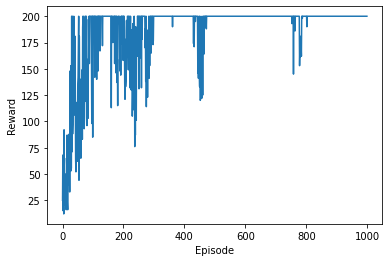

In [ ]:
import matplotlib.pyplot as plt
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In the resulting plot, we can see a clear upward trend before it stays at the maximum value. We can also see that the rewards oscillate even after it converges. This is because the policy gradient algorithm is a stochastic policy.

Now, let's see how the learned policy performs on 100 new episodes:

In [ ]:
n_episode_eval = 100
total_rewards_eval = []
for episode in range(n_episode_eval):
    total_reward, _ = run_episode(env, weight)
    print('Episode {}: {}'.format(episode+1, total_reward))
    total_rewards_eval.append(total_reward)


print('Average total reward over {} episode: {}'.format(n_episode, sum(total_rewards_eval) / n_episode_eval))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 1: 200.0
Episode 2: 200.0
Episode 3: 200.0
Episode 4: 200.0
Episode 5: 200.0
Episode 6: 200.0
Episode 7: 200.0
Episode 8: 200.0
Episode 9: 200.0
Episode 10: 200.0
Episode 11: 200.0
Episode 12: 200.0
Episode 13: 200.0
Episode 14: 200.0
Episode 15: 200.0
Episode 16: 200.0
Episode 17: 200.0
Episode 18: 200.0
Episode 19: 200.0
Episode 20: 200.0
Episode 21: 200.0
Episode 22: 200.0
Episode 23: 200.0
Episode 24: 200.0
Episode 25: 200.0
Episode 26: 200.0
Episode 27: 200.0
Episode 28: 200.0
Episode 29: 200.0
Episode 30: 200.0
Episode 31: 200.0
Episode 32: 200.0
Episode 33: 200.0
Episode 34: 200.0
Episode 35: 200.0
Episode 36: 200.0
Episode 37: 200.0
Episode 38: 200.0
Episode 39: 200.0
Episode 40: 200.0
Episode 41: 200.0
Episode 42: 200.0
Episode 43: 200.0
Episode 44: 200.0
Episode 45: 200.0
Episode 46: 200.0
Episode 47: 200.0
Episode 48: 200.0
Episode 49: 200.0
Episode 50: 200.0
Episode 51: 200.0
Episode 52: 200.0
Episode 53: 200.0
Episode 54: 200.0
Episode 55: 200.0
Episode 56: 200.0
E

The average reward for the testing episodes is close to the maximum value of 200 for the learned policy. You can re-run the evaluation multiple times. The results are pretty consistent.

The policy gradient algorithm trains an agent by taking small steps and updating the weight based on the rewards associated with those steps at the end of an episode. The technique of having the agent run through an entire episode and then updating the policy based on the rewards obtained is called Monte Carlo policy gradient.

The action is selected based on the probability distribution computed based on the current state and the model’s weight. For example, if the probabilities for the left and right actions are [0.6, 0.4], this means the left action is selected 60% of the time; it doesn't mean the left action is chosen, as in the random search and hill-climbing algorithms.

We know that the reward is 1 for each step before an episode terminates. Hence, the future reward we use to calculate the policy gradient at each step is the number of steps remaining. After each episode, we feed the gradient history multiplied by the future rewards to update the weight using the stochastic gradient ascent method. In this way, the longer an episode is, the bigger the update of the weight. This will eventually increase the chance of getting a larger total reward.